<a href="https://colab.research.google.com/github/areegtarek/Topic-Modeling-for-Scientific-Paper-Abstract/blob/main/text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling for Scientific Paper Abstract**

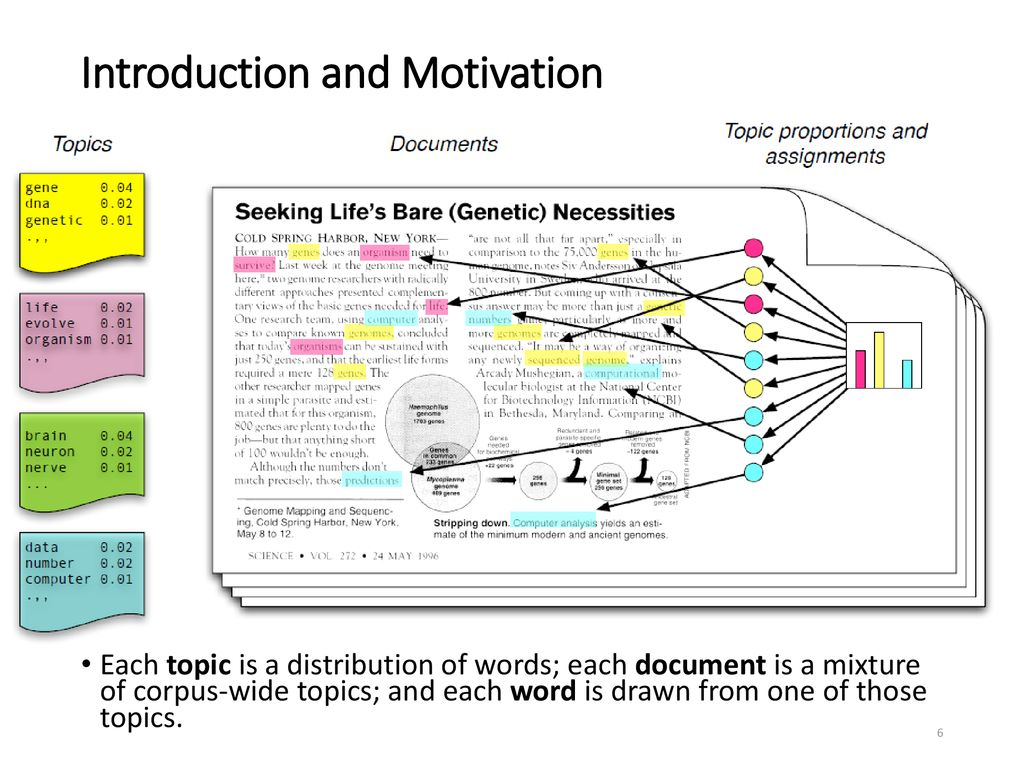

**Our goal is to cluster papers based on their Abstract.**

Paper data avaialble at: https://www.kaggle.com/datasets/Cornell-University/arxiv 

sampled_arxiv_cs.csv that contains 50,000 randomly sampled papers from the above huge arxiv data corpus.


# **Importing Necessary Libraries and datasets**

In [ ]:
pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz (538.1 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers==4.6.1 accelerate==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.6.1-py3-none-any.whl (2.2 MB)
  Using cached accelerate-0.4.0-py3-none-any.whl (55 kB)
  Using cached huggingface_hub-0.0.8-py3-none-any.whl (34 kB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd                                        
import numpy as np                                        
import matplotlib.pyplot as plt                           
import seaborn as sns    
import missingno as msno
from bertopic import BERTopic
from tqdm import tqdm

# Set up interactive shell to display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Configure Pandas to display full width
pd.options.display.width = None

# Import Spacy and stop words
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 

# Import SciSpacy large model
import en_core_sci_lg

# Import string library for string operations
import string

# Import MiniSom for Self-Organizing Maps clustering
from minisom import MiniSom  

# Import SpectralClustering for spectral clustering
from sklearn.cluster import SpectralClustering 

# Import hierarchical clustering from scipy
import scipy.cluster.hierarchy as sch

# Import PCA for dimensionality reduction 
from sklearn.decomposition import PCA

# Import TfidfVectorizer for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Sort stopwords alphabetically
from spacy.lang.en.stop_words import STOP_WORDS 
STOP_WORDS = sorted(list(STOP_WORDS))

# **Explore Data**

**Question 1: Load in the provided dataset and summarize the basic statistics. Specifically your code should answer:**

    1) What are the feature types and their basic statistics (using describe(include='all'))
    2) How many features have missing values?

In [ ]:
# as usual, let's first check the basic statistics of the dataset, it should contain 100k recordds.
df = pd.read_csv('/content/drive/MyDrive/Data Mining&DL/Data Analytics /sampled_arxiv_cs.csv')
df.head()
df.info()

<ipython-input-9-34a9aa13ec63>:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Data Mining&DL/Data Analytics /sampled_arxiv_cs.csv')


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,2006.15607,Youngwan Lee,"Youngwan Lee, Joong-won Hwang, Hyung-Il Kim, K...",Localization Uncertainty Estimation for Anchor...,NaN,NaN,NaN,NaN,cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,"Since many safety-critical systems, such as ...","[{'version': 'v1', 'created': 'Sun, 28 Jun 202...",2022-07-07,"[['Lee', 'Youngwan', ''], ['Hwang', 'Joong-won..."
1,1507.03782,Helmut Strobel,"Helmut Strobel, Wolfgang Muessel, Daniel Linne...",Fisher Information and entanglement of non-Gau...,"5 pages, 4 figures, 7 pages supplementary mate...","Science 345, 424-427 (2014)",10.1126/science.1250147,NaN,quant-ph cond-mat.quant-gas physics.atom-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Entanglement is the key quantum resource for...,"[{'version': 'v1', 'created': 'Tue, 14 Jul 201...",2015-07-15,"[['Strobel', 'Helmut', ''], ['Muessel', 'Wolfg..."
2,901.4201,Stephane Martin,"Denis Lugiez (LIF), St\'ephane Martin (LIF)",Peer to Peer Optimistic Collaborative Editing ...,NaN,NaN,NaN,NaN,cs.DS,http://arxiv.org/licenses/nonexclusive-distrib...,Collaborative editing consists in editing a ...,"[{'version': 'v1', 'created': 'Tue, 27 Jan 200...",2009-01-28,"[['Lugiez', 'Denis', '', 'LIF'], ['Martin', 'S..."
3,1802.05814,Dawen Liang,"Dawen Liang, Rahul G. Krishnan, Matthew D. Hof...",Variational Autoencoders for Collaborative Fil...,"10 pages, 3 figures. WWW 2018",NaN,NaN,NaN,stat.ML cs.IR cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,We extend variational autoencoders (VAEs) to...,"[{'version': 'v1', 'created': 'Fri, 16 Feb 201...",2018-02-19,"[['Liang', 'Dawen', ''], ['Krishnan', 'Rahul G..."
4,1010.5069,Philippe Maincon,Philippe Maincon,A Wiener-Laguerre model of VIV forces given re...,NaN,NaN,NaN,NaN,physics.flu-dyn,http://arxiv.org/licenses/nonexclusive-distrib...,Slender structures immersed in a cross flow ...,"[{'version': 'v1', 'created': 'Mon, 25 Oct 201...",2010-10-26,"[['Maincon', 'Philippe', '']]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              50000 non-null  object
 1   submitter       49959 non-null  object
 2   authors         50000 non-null  object
 3   title           50000 non-null  object
 4   comments        31780 non-null  object
 5   journal-ref     10783 non-null  object
 6   doi             15365 non-null  object
 7   report-no       1170 non-null   object
 8   categories      50000 non-null  object
 9   license         47468 non-null  object
 10  abstract        50000 non-null  object
 11  versions        50000 non-null  object
 12  update_date     50000 non-null  object
 13  authors_parsed  50000 non-null  object
dtypes: object(14)
memory usage: 10.7+ MB


In [ ]:
# Print the shape of the dataset
print('Shape of dataset:', df.shape)

# Print the column names
print('Columns:', df.columns)

# Print the data types of each column
print('Data types:')
print(df.dtypes)

# Print the summary statistics of the numerical columns
print('Summary statistics:')
print(df.describe(include="all"))

Shape of dataset: (100000, 14)
Columns: Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')
Data types:
id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object
Summary statistics:
                id submitter        authors  \
count        50000     49959          50000   
unique       50000     40229          48953   
top     2006.15607     EPTCS  Lorenzo Iorio   
freq             1       216             11   

                                                    title  comments  \
count                                        

In [ ]:
#Identifying and selecting categorical features in the dataframe
cat_features = df.select_dtypes(include=['object']).columns.tolist() # selecting columns with object datatype as categorical features
print("Categorical features:", cat_features) # printing the list of identified categorical features

#Identifying and selecting quantitative features in the dataframe
num_features = df.select_dtypes(include=['float64']).columns.tolist() # selecting columns with float64 datatype as quantitative features
print("Quantitative features:", num_features) # printing the list of identified quantitative features

Categorical features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']
Quantitative features: []


All The data types are "object" (categorical).

In [ ]:
df.duplicated().sum()

49999

In [ ]:
# Calculate percentage of duplicated rows
duplicated_pct = df.duplicated().mean() * 100

# Print result
print(f"{duplicated_pct:.2f}% of rows in the DataFrame are duplicates.")

50.00% of rows in the DataFrame are duplicates.


In [ ]:
df.nunique()

id                50000
submitter         40229
authors           48953
title             49998
comments          23292
journal-ref       10709
doi               15362
report-no          1157
categories         8908
license               9
abstract          49996
versions          49984
update_date        3955
authors_parsed    48801
dtype: int64

In [ ]:
# Count number of features with missing values
print(f"Number of features with missing values: {df.isnull().any().sum()}")

Number of features with missing values: 14


In [ ]:
# looking at the percentage of missing values 
missing_percent  = df.isnull().sum() * 100 / len(df)
missing_percent

id                50.000
submitter         50.041
authors           50.000
title             50.000
comments          68.220
journal-ref       89.217
doi               84.635
report-no         98.830
categories        50.000
license           52.532
abstract          50.000
versions          50.000
update_date       50.000
authors_parsed    50.000
dtype: float64

In [ ]:
# Identify patterns and potential reasons for missing values
top_missing = df.isnull().sum().sort_values(ascending=False)[:3]
print("Top 3 features with missing values:")
for feature, count in top_missing.iteritems():
    print(f"- {feature}: {count} missing values ({100*count/len(df):.2f}% of total)")
    print(f"  Example missing values: {df[feature].dropna().sample(3).values}\n")

Top 3 features with missing values:
- report-no: 98830 missing values (98.83% of total)
  Example missing values: ['RR-6666' 'UAI-P-1992-PG-142-148' 'Report:9-1-1999']

- journal-ref: 89217 missing values (89.22% of total)
  Example missing values: ['J. Appl. Phys. 116, 033101 (2014)'
 'EuroPhysics Letters. v. 68, (6), pp. 825-831 (2004),'
 'Scientific Reports, 12, 9868 (2022)']

- doi: 84635 missing values (84.64% of total)
  Example missing values: ['10.1103/PhysRevA.105.L051501' '10.1103/PhysRevB.99.115428'
 '10.1103/PhysRevB.106.064304']



<Axes: >

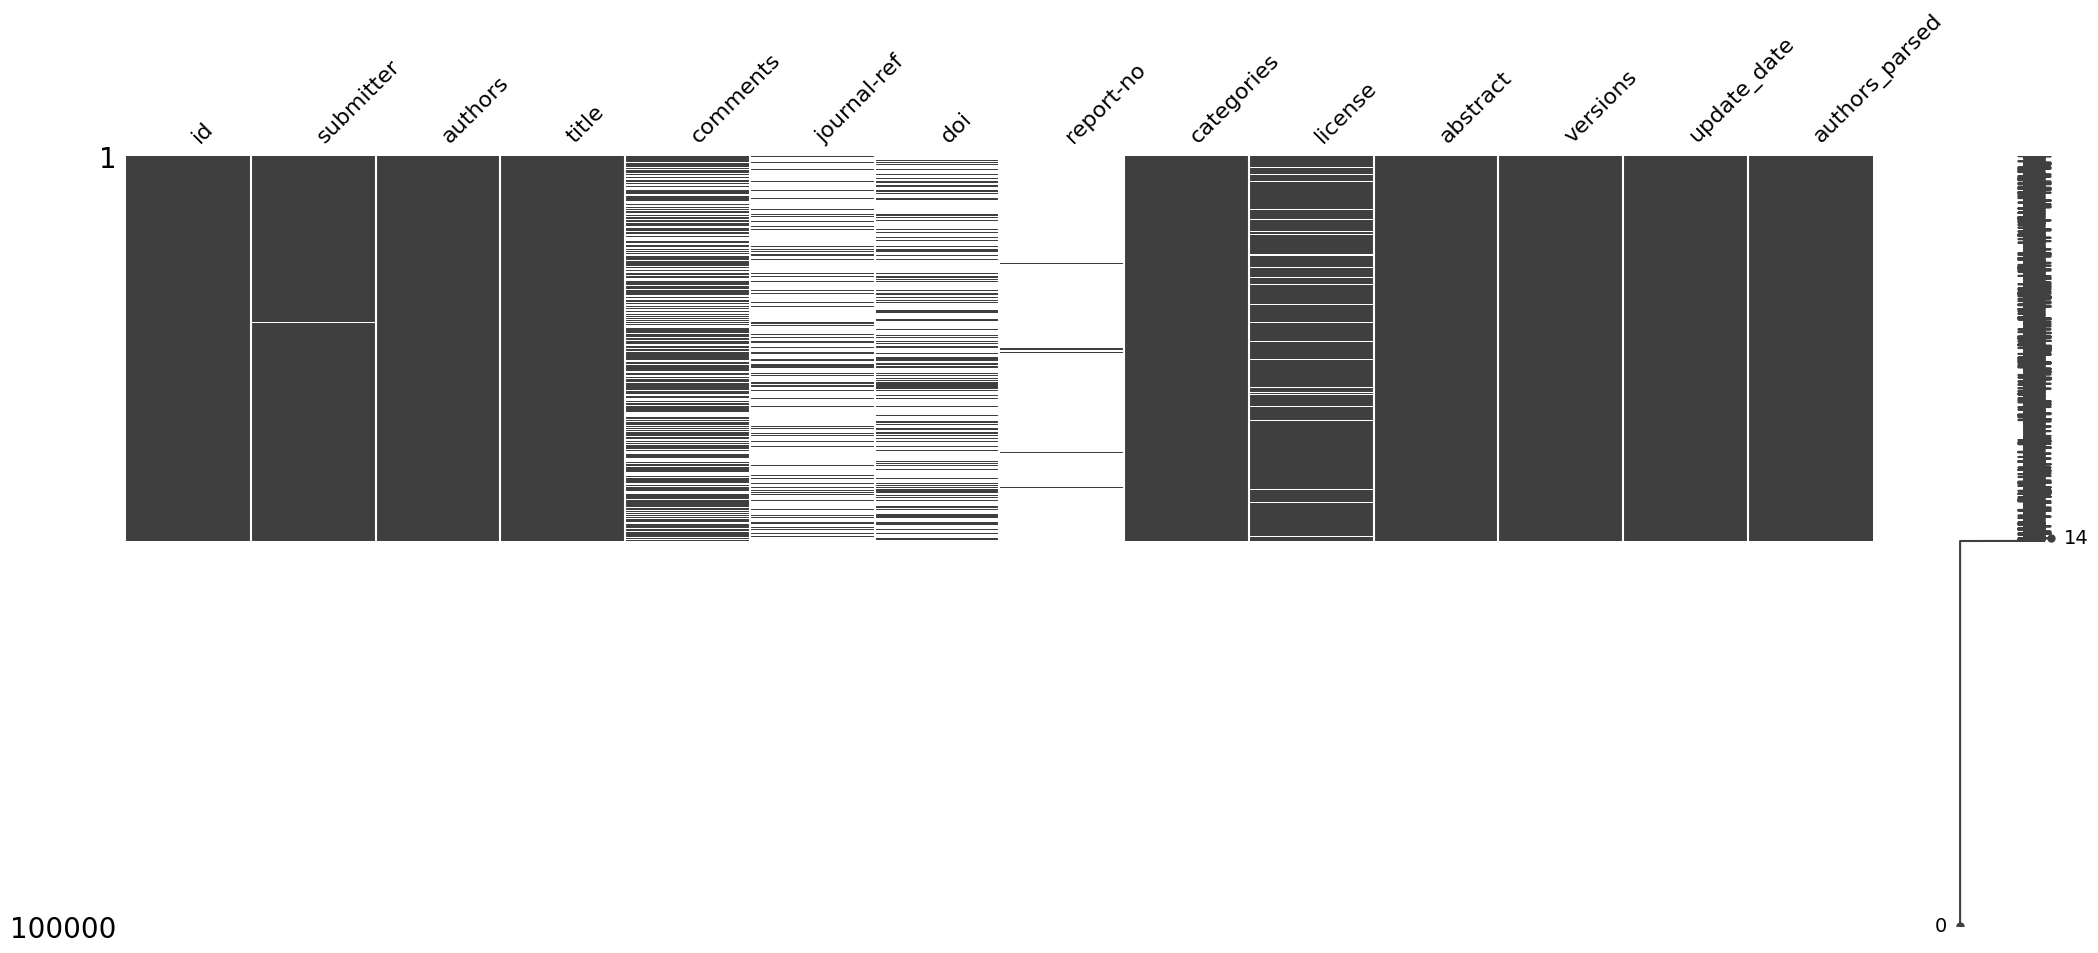

In [ ]:
# Visualize the missing values before replace zeross with nan
msno.matrix(df)

<Axes: >

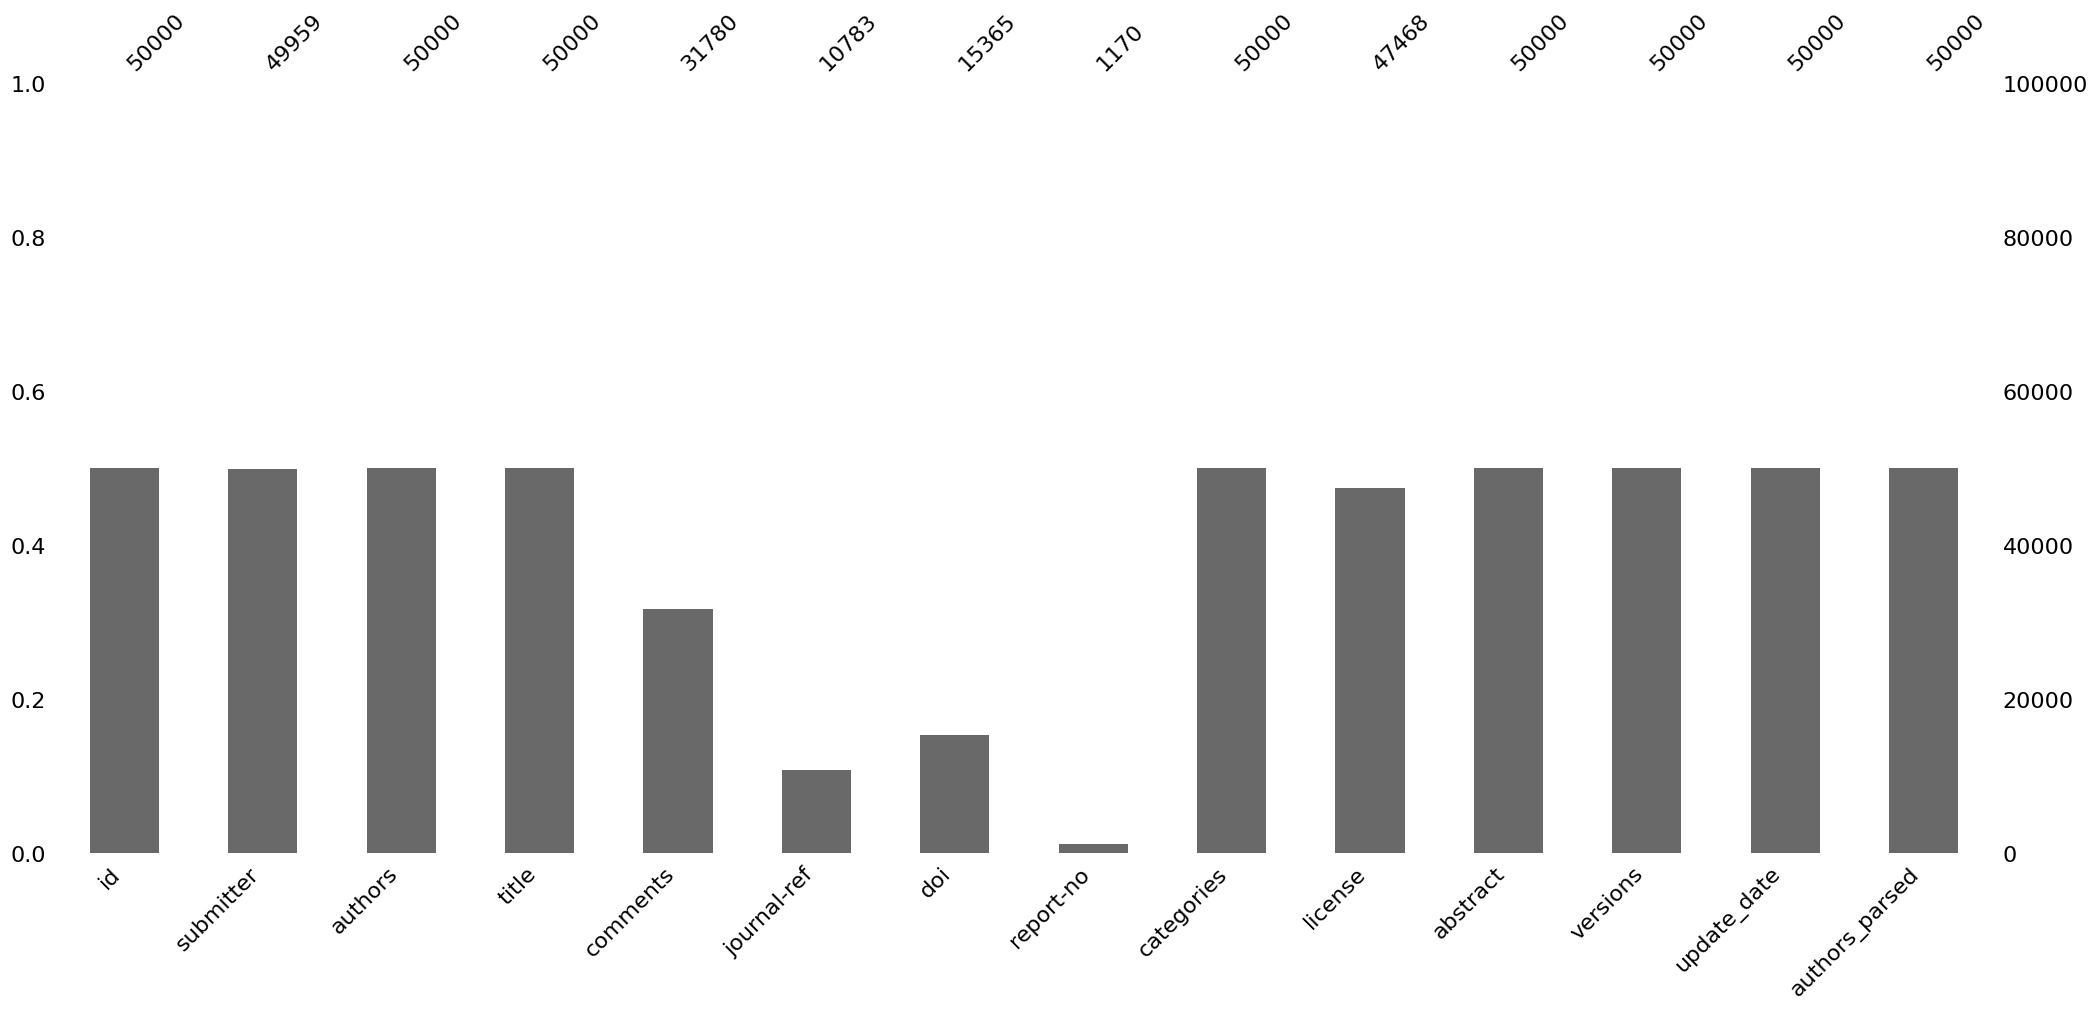

In [ ]:
# Plot the missing values in the dataframe
msno.bar(df)
plt.show()

pattern of missing values is a general pattern: (completely at random)

In [ ]:
df.duplicated().sum()

49999

In [ ]:
# Calculate percentage of duplicated rows
duplicated_pct = df.duplicated().mean() * 100

# Print result
print(f"{duplicated_pct:.2f}% of rows in the DataFrame are duplicates.")

50.00% of rows in the DataFrame are duplicates.


**Question 2: Preprocess the abstracts of the papers in the provided data corpus, Apply bertopic on the abstracts and explain the topics you received and discuss the quality of the topics and determine what is the optimal topic number for abstracts.**

# **Data Cleaning**

We interested in abstract column and categories so we will create new_df with two columns

In [ ]:
new_df=df[["categories","abstract"]]

In [ ]:
# Count number of features with missing values
print(f"Number of features with missing values: {new_df.isnull().any().sum()}")

Number of features with missing values: 2


In [ ]:
# looking at the percentage of missing values 
missing_percent  = new_df.isnull().sum() * 100 / len(new_df)
missing_percent

categories    50.0
abstract      50.0
dtype: float64

In [ ]:
# Identify patterns and potential reasons for missing values
top_missing = new_df.isnull().sum().sort_values(ascending=False)[:3]
print("Top 3 features with missing values:")
for feature, count in top_missing.iteritems():
    print(f"- {feature}: {count} missing values ({100*count/len(new_df):.2f}% of total)")
    print(f"  Example missing values: {new_df[feature].dropna().sample(3).values}\n")

Top 3 features with missing values:
- categories: 50000 missing values (50.00% of total)
  Example missing values: ['cs.NI' 'physics.hist-ph' 'math.NA cs.NA']

- abstract: 50000 missing values (50.00% of total)
  Example missing values: ['  Virtualization started to gain traction in the domain of information\ntechnology in the early 2000s when managing resource distribution was becoming\nan uphill task for developers. As a result, tools like VMWare, Hyper V\n(hypervisor) started making inroads into the software repository on different\noperating systems. VMWare and Hyper V could support multiple virtual machines\nrunning on them with each having their own isolated environment. Due to this\nisolation, the security aspects of virtual machines (VMs) did not differ much\nfrom that of physical machines (having a dedicated operating system on\nhardware). The advancement made in the domain of linux containers (LXC) has\ntaken virtualization to an altogether different level where resource\nuti

In [ ]:
# Print rows where categories is 'cs.GT cs.LO', 'physics.soc-ph', or 'physics.ao-ph'
categories_to_print = ['cs.GT cs.LO', 'physics.soc-ph', 'physics.ao-ph']
print(new_df[new_df['categories'].isin(categories_to_print)])

           categories                                           abstract
17     physics.soc-ph    A distinction in reasons and motives for cho...
86     physics.soc-ph    In this article we develop a highly integrat...
222    physics.soc-ph    The ability to sample random networks that c...
255    physics.soc-ph    We analyze the public transport networks (PT...
294    physics.soc-ph    Models of street networks underlie research ...
...               ...                                                ...
48569   physics.ao-ph    Effects of wave-driven Langmuir turbulence o...
48763  physics.soc-ph    The steady-state and nonequilibrium properti...
49267  physics.soc-ph    Many real-world networks are so large that w...
49425   physics.ao-ph    This work is intended to be a contribution t...
49490  physics.soc-ph    Electric vehicles, noted EV, with smaller en...

[349 rows x 2 columns]


<Axes: >

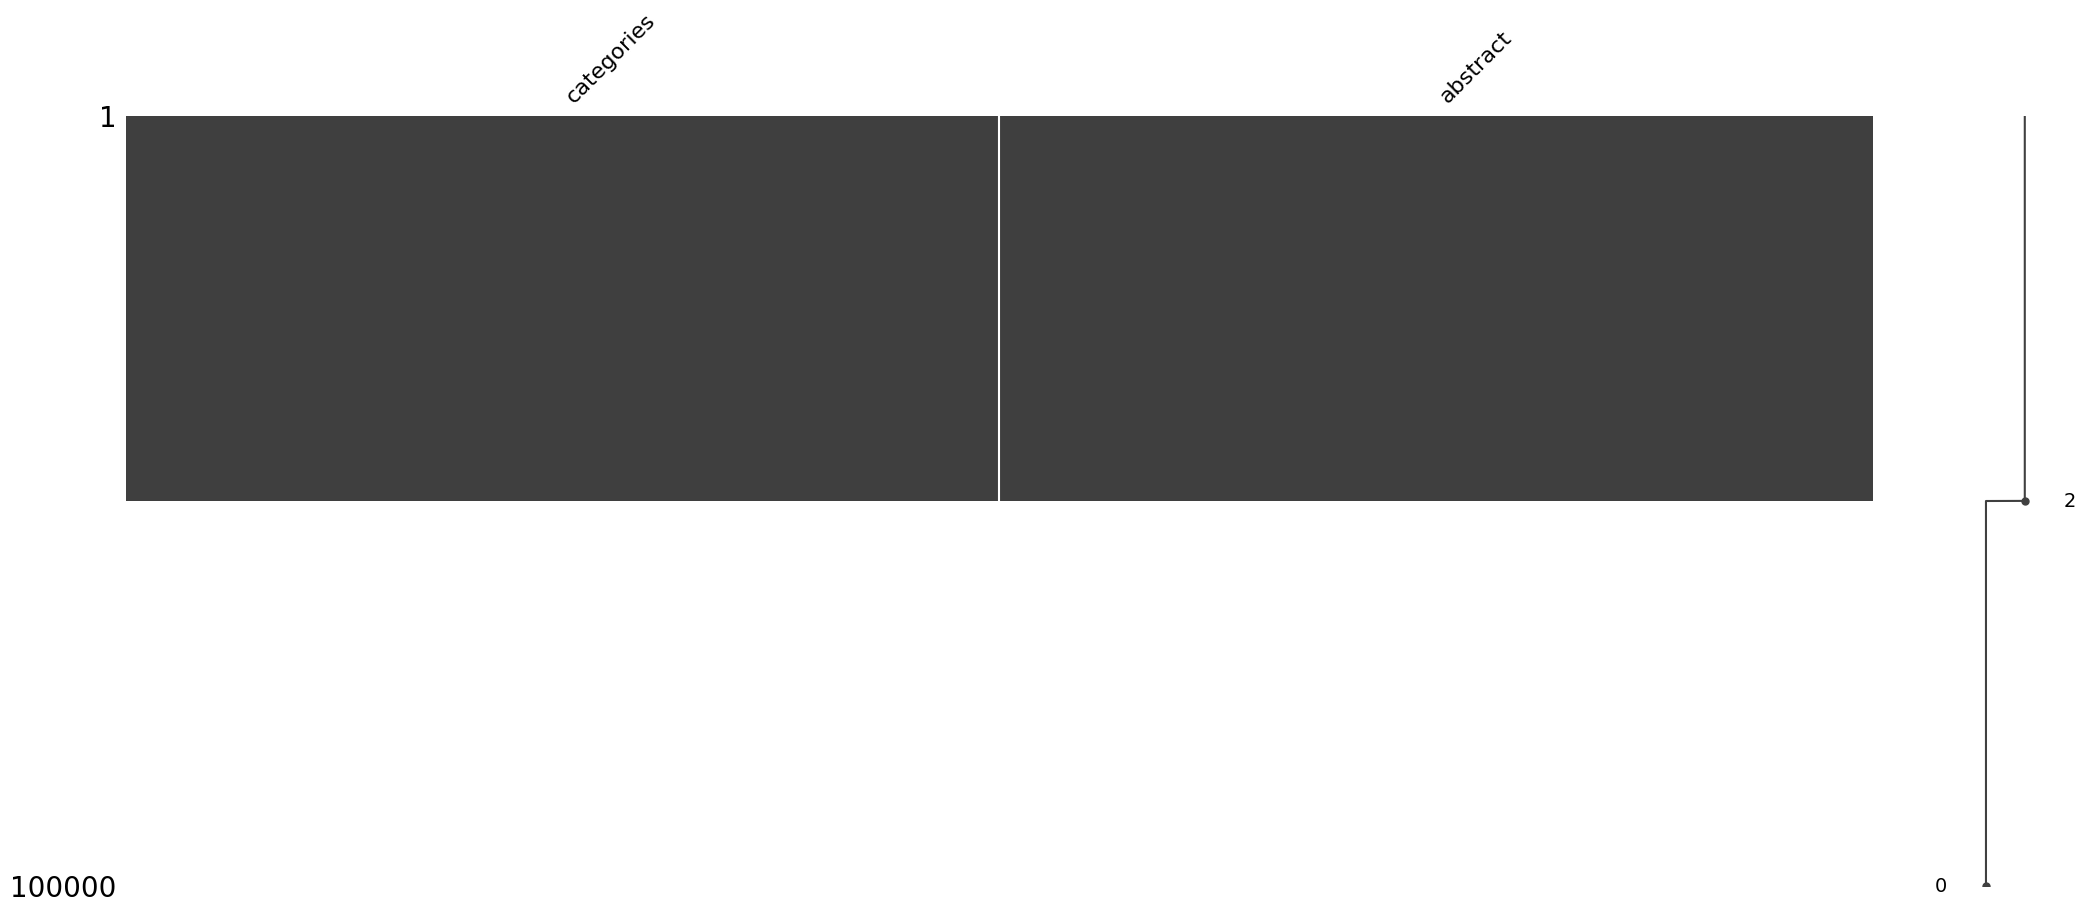

In [ ]:
# Visualize the missing values before replace zeross with nan
msno.matrix(new_df)

<Axes: >

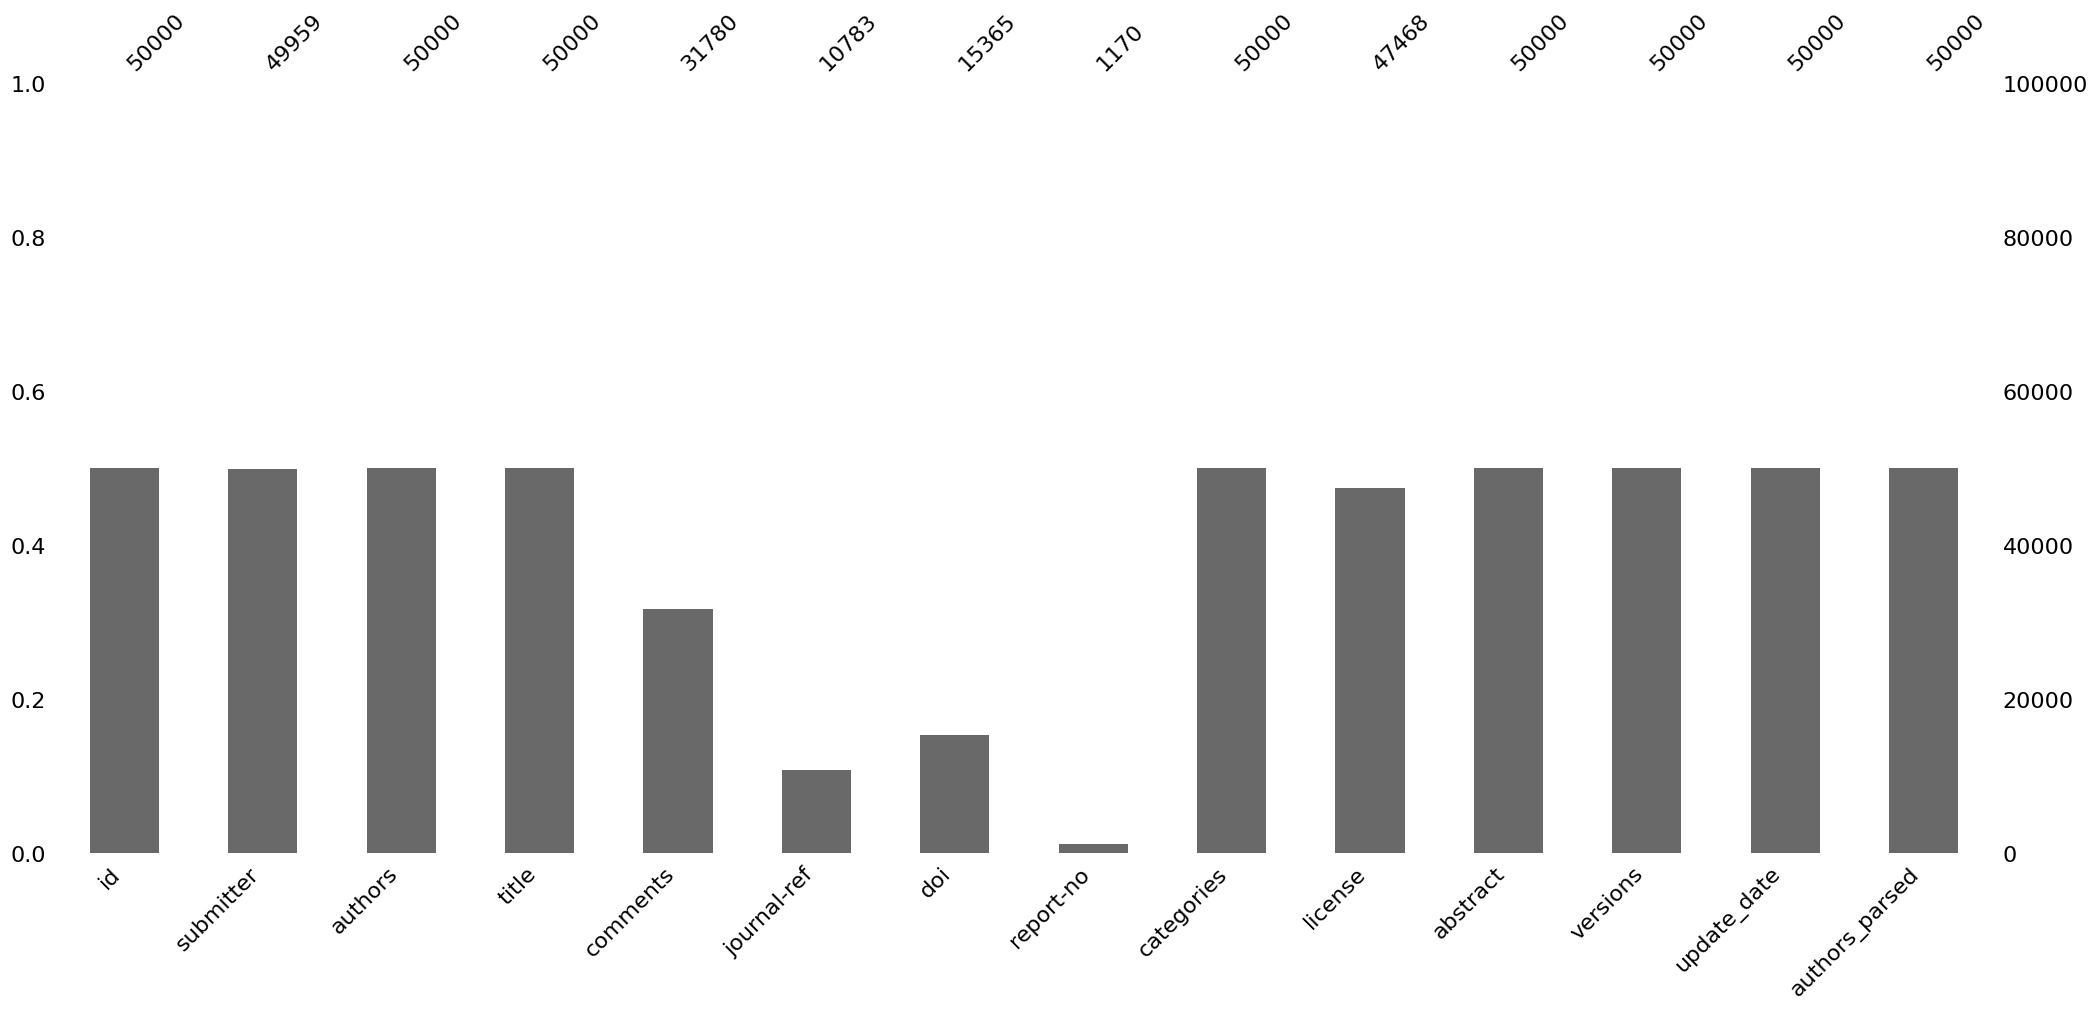

In [ ]:
# Plot the missing values in the dataframe
msno.bar(df)
plt.show()

In [ ]:
new_df.duplicated().sum()

50002

In [ ]:
# Calculate percentage of duplicated rows
duplicated_pct = new_df.duplicated().mean() * 100

# Print result
print(f"{duplicated_pct:.2f}% of rows in the DataFrame are duplicates.")

50.00% of rows in the DataFrame are duplicates.


missing values rows is the same the duplicates row in the new dataframe that contains the abstract and catigores columns only there are a 50000 row all the values in columns are null 

In [ ]:
new_df.dropna(subset='abstract',inplace=True)

In [ ]:
new_df.isna().sum()

categories    0
abstract      0
dtype: int64

In [ ]:
new_df.duplicated().sum()

3

In [ ]:
# Drop duplicate rows from new_df
new_df.drop_duplicates(inplace=True)

# Check the number of duplicates after dropping them
print(new_df.duplicated().sum())

0


In [ ]:
# Compute the category counts and percentages
categories = {}
total_papers = len(new_df)
for paper_categories in new_df['categories']:
    for category in paper_categories.split():
        if category not in categories:
            categories[category] = 1
        else:
            categories[category] += 1
category_percentages = {category: count / total_papers * 100 for category, count in categories.items()}

# Print the results
print(f"Total number of categories: {len(categories)}")
for category, count in categories.items():
    percentage = category_percentages[category]
    print(f"{category}: {count} papers ({percentage:.2f}%)")

Total number of categories: 167
cs.CV: 6585 papers (13.17%)
quant-ph: 1808 papers (3.62%)
cond-mat.quant-gas: 256 papers (0.51%)
physics.atom-ph: 1374 papers (2.75%)
cs.DS: 1530 papers (3.06%)
stat.ML: 3568 papers (7.14%)
cs.IR: 947 papers (1.89%)
cs.LG: 9398 papers (18.80%)
physics.flu-dyn: 1704 papers (3.41%)
physics.optics: 2834 papers (5.67%)
math.GR: 41 papers (0.08%)
cs.FL: 299 papers (0.60%)
math.NA: 1327 papers (2.65%)
cs.NE: 853 papers (1.71%)
math.DS: 268 papers (0.54%)
eess.SY: 1158 papers (2.32%)
cs.SY: 1725 papers (3.45%)
eess.SP: 987 papers (1.97%)
cs.IT: 2935 papers (5.87%)
math.IT: 2935 papers (5.87%)
physics.ins-det: 1365 papers (2.73%)
astro-ph.SR: 312 papers (0.62%)
physics.space-ph: 395 papers (0.79%)
hep-ex: 555 papers (1.11%)
cs.AI: 4297 papers (8.59%)
physics.soc-ph: 1359 papers (2.72%)
cs.DM: 859 papers (1.72%)
cs.DB: 545 papers (1.09%)
physics.class-ph: 615 papers (1.23%)
physics.gen-ph: 751 papers (1.50%)
cs.CR: 1868 papers (3.74%)
astro-ph.IM: 351 papers (0.7

# **NLP data preprocessing**

In [ ]:
# Now let's create a tokenizer 
parser = en_core_sci_lg.load()
parser.max_length = 7000000 #Limit the size of the parser
punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)


def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [ ]:
punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across']

In [ ]:
# Apply the tokenizer to process title, we will use the processed_text as the input for clustering task, but feel free to compare with just using the raw titles.
tqdm.pandas()

# Function to handle float values in the "title" column
def handle_float_value(value):
    if isinstance(value, float):
        return str(value)  # Convert float to string 
    return value

# Apply the tokenizer to the "title" column
new_df["processed_text"] = new_df["abstract"].apply(handle_float_value).progress_apply(spacy_tokenizer)

100%|██████████| 49997/49997 [29:36<00:00, 28.15it/s]


In [ ]:
new_df['abstract']

0          Since many safety-critical systems, such as ...
1          Entanglement is the key quantum resource for...
2          Collaborative editing consists in editing a ...
3          We extend variational autoencoders (VAEs) to...
4          Slender structures immersed in a cross flow ...
                               ...                        
49995      Analysis of 1H-NMR spectra is often hindered...
49996      The thrust benefits of lateral configuration...
49997      A constant magnetic field has frequently bee...
49998      Virtual Mental Health Assistants (VMHAs) hav...
49999      The problem of estimating frequency moments ...
Name: abstract, Length: 49997, dtype: object

# **Model Training: BERTopic**

In [ ]:
# now let's create a topic model using BERTopic 

# since we have quite a lot data points, let's start with a large topic number (50) and see how coherent are the learned topics.
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L6-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(new_df["processed_text"].to_numpy()); len(topic_model.get_topic_info())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-05 21:06:37,102 - BERTopic - Transformed documents to Embeddings
2023-06-05 21:07:51,279 - BERTopic - Reduced dimensionality
2023-06-05 21:07:57,396 - BERTopic - Clustered reduced embeddings


102

# **Topic Representation**

In [ ]:
# the following commands would help you to explore the topics generated. For the details of those functions, check bertopic functions.
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,26082,-1_model_use_method_datum,"[model, use, method, datum, propose, result, p...",[offline handwritten text recognition image im...
1,0,1823,0_channel_interference_wireless_antenna,"[channel, interference, wireless, antenna, use...",[paper address network code design robust tran...
2,1,942,1_image_segmentation_imaging_medical,"[image, segmentation, imaging, medical, ct, mr...",[key feature magnetic resonance mr imaging abi...
3,2,835,2_robot_robotic_human_object,"[robot, robotic, human, object, control, motio...",[robotic network system multiple robot connect...
4,3,781,3_logic_program_calculus_proof,"[logic, program, calculus, proof, type, langua...",[develop framework epistemic logic combine rel...
...,...,...,...,...,...
97,96,52,96_vr_virtual_reality_user,"[vr, virtual, reality, user, experience, inter...",[virtual reality vr re-emerge low-cost highly ...
98,97,51,97_underwater_ship_fish_image,"[underwater, ship, fish, image, marine, detect...",[underwater image suffer color cast low contra...
99,98,51,98_forgetting_continual_catastrophic_learning,"[forgetting, continual, catastrophic, learning...",[human remarkable ability quickly effectively ...
100,99,51,99_pca_principal_component_sne,"[pca, principal, component, sne, analysis, sub...",[propose novel value function approximation te...


In [ ]:
# Get the number of topics
topic_freq = topic_model.get_topic_freq()
num_topics = len(topic_freq)

print(f"Number of topics: {num_topics}")

Number of topics: 102


In [ ]:
topic_model.visualize_barchart(top_n_topics=9, height=700)

In [ ]:
topic_model.visualize_term_rank()

# **Topic Relationships**

In [ ]:
topic_model.visualize_topics(top_n_topics=21)

In [ ]:
topic_model.visualize_barchart(top_n_topics=10, height=700)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=21, width=800)

In [ ]:
topic_model.visualize_topics(top_n_topics=10)

In [ ]:
topic_model.visualize_topics(top_n_topics=50)

In [ ]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=21)

In [ ]:
# Find the optimal number of topics
result = topic_model.find_topics(new_df['processed_text'].tolist(), range(5, 200, 5))
print(result)

([15, 79, 83, -1, 24], [0.6871551, 0.6198144, 0.6142078, 0.5580678, 0.54809964])


In [ ]:
#reduce the number of topics to 90 

topic_model.reduce_topics(new_df["processed_text"].to_numpy(),nr_topics=15)
topics = topic_model.topics_

2023-06-05 21:08:23,885 - BERTopic - Reduced number of topics from 102 to 15


In [ ]:
topic_model.visualize_term_rank()

In [ ]:
topic_model.visualize_topics(top_n_topics=21)

In [ ]:
topic_model.visualize_barchart(top_n_topics=10, height=700)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=21, width=800)

In [ ]:
topic_model.visualize_topics(top_n_topics=10)

In [ ]:
topic_model.visualize_topics(top_n_topics=50)

In [ ]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=21)

Question 3: Compare the topics learned by BERTopic with the original categories of the papers. 
For instance, you can pick one popular category, such as cs.CV, and check how those papers belong to this category are cateogrized by your topic model learned in previous step. 

In [ ]:
# Add topics to the data
new_df['topic'] = topics

# Select the papers belonging to a specific category, e.g., cs.CV
ComputerVison_papers = new_df[new_df['categories'] == 'cs.CV']

# Check the distribution of topics for cs.CV papers
ComputerVison_papers['topic'].value_counts()

-1    1763
 0    1280
 1      40
 2      13
 3       5
 9       2
 5       2
Name: topic, dtype: int64

In [ ]:
cs_cv_indices = new_df[new_df['categories'] == 'cs.CV'].index

In [ ]:
cs_cv_topics = pd.Series(topics)[cs_cv_indices]

In [ ]:
cs_cv_topic_counts = cs_cv_topics.value_counts()

In [ ]:
num_top_topics = 5
top_cs_cv_topics = cs_cv_topic_counts.head(num_top_topics)
for topic_num, count in top_cs_cv_topics.items():
    print(f"Topic {topic_num}: {count} papers in cs.CV category.")

Topic -1: 1644 papers in cs.CV category.
Topic 0: 726 papers in cs.CV category.
Topic 1: 233 papers in cs.CV category.
Topic 2: 140 papers in cs.CV category.
Topic 3: 83 papers in cs.CV category.


Question 4: Redo the topic modeling using the same method, but only on the papers tagged by the category you chcked in Q3. For instance, in Q3, you pick cs.CV, then in Q4, you first filter data by category = cs.CV and then apply the topic modeling on the selected documents.
Compare your topics found and your results from Q3. 

In [ ]:
cs_cv_df = new_df[new_df['categories'] == 'cs.CV']
cs_cv_papers = cs_cv_df['processed_text'].tolist()

In [ ]:
cs_cv_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L6-v2", min_topic_size=50)
cs_cv_topic_labels, _ = cs_cv_model.fit_transform(cs_cv_papers); len(topic_model.get_topic_info())

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

2023-06-05 21:08:32,506 - BERTopic - Transformed documents to Embeddings
2023-06-05 21:08:48,532 - BERTopic - Reduced dimensionality
2023-06-05 21:08:48,757 - BERTopic - Clustered reduced embeddings


15

In [ ]:
num_top_topics = 5
cs_cv_topic_counts = pd.Series(cs_cv_topic_labels).value_counts()
top_cs_cv_topics = cs_cv_topic_counts.head(num_top_topics)
for topic_num, count in top_cs_cv_topics.items():
    print(f"Topic {topic_num}: {count} papers in cs.CV category.")

Topic -1: 1392 papers in cs.CV category.
Topic 0: 389 papers in cs.CV category.
Topic 1: 243 papers in cs.CV category.
Topic 2: 222 papers in cs.CV category.
Topic 3: 217 papers in cs.CV category.


**Topic Representation**

In [ ]:
# the following commands would help you to explore the topics generated. For the details of those functions, check bertopic functions.
cs_cv_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1392,-1_image_method_propose_model,"[image, method, propose, model, use, feature, ...",[exploit synthetic datum learn deep model attr...
1,0,389,0_network_domain_model_training,"[network, domain, model, training, propose, fe...",[deep convolutional neural network dcnn base s...
2,1,243,1_object_text_detection_image,"[object, text, detection, image, tracking, fea...",[tracking detection dominant approach online m...
3,2,222,2_video_action_frame_temporal,"[video, action, frame, temporal, motion, metho...",[learn recognize action handful label video ch...
4,3,217,3_segmentation_image_medical_use,"[segmentation, image, medical, use, method, pr...",[image segmentation important task medical app...
5,4,202,4_face_facial_recognition_propose,"[face, facial, recognition, propose, image, us...",[automatic face recognition research area high...
6,5,196,5_point_3d_vehicle_detection,"[point, 3d, vehicle, detection, lidar, cloud, ...",[address problem 3d object detection estimate ...
7,6,132,6_image_3d_shape_surface,"[image, 3d, shape, surface, method, reconstruc...",[achieve promising result shape color recovery...
8,7,112,7_pose_human_hand_3d,"[pose, human, hand, 3d, body, estimation, mode...",[deep learning approach rapidly adopt wide ran...


In [ ]:
# Get the number of topics
topic_freq = cs_cv_model.get_topic_freq()
num_topics = len(topic_freq)

print(f"Number of topics: {num_topics}")

Number of topics: 9


In [ ]:
cs_cv_model.visualize_barchart(top_n_topics=9, height=700)

In [ ]:
cs_cv_model.visualize_term_rank()

**Topic Relationships**

In [ ]:
cs_cv_model.visualize_topics(top_n_topics=21)

In [ ]:
cs_cv_model.visualize_barchart(top_n_topics=10, height=700)

In [ ]:
cs_cv_model.visualize_hierarchy(top_n_topics=21, width=800)

In [ ]:
cs_cv_model.visualize_topics(top_n_topics=10)

In [ ]:
cs_cv_model.visualize_topics(top_n_topics=50)

In [ ]:
cs_cv_model.visualize_heatmap(n_clusters=5, top_n_topics=21)